# T Learner

T-Learner je meta-learner koji koristi dva modela masinskog ucenja za procenu heterogenog kauzalnog efekta tretmana na individualnom nivou.
T-Learner je meta-learner koji koristi dva modela masinskog ucenja za procenu heterogenog kauzalnog efekta tretmana na individualnom nivou.

Ovaj algoritam prati tri koraka za procenu individualnog tretmana ITE:
* Prvo je potrebno izgraditi dva modela masinskog ucenja, jedan koji koristi tretirane klijente, a drugi koji koristi klijente iz kontrolne grupe.
* Nakon toga, predvidjanja ce biti napravljena odvojeno koriscenjem dva modela za tretirane i kontrolne klijente.
* Efekat individualnog tretmana ITE bice procenjen dobijanjem razlike izmedju predvidjenog ishoda iz tretiranog modela i iz kontrolnog modela.

In [0]:
!pip install causalml

Looking in indexes: https://artifacts.rbi.tech/artifactory/api/pypi/pypi-org-pypi-proxy/simple/
  Using cached causalml-0.13.0-cp39-cp39-linux_x86_64.whl
  Using cached https://artifacts.rbi.tech/artifactory/api/pypi/pypi-org-pypi-proxy/packages/packages/57/78/3f3a6c8f9447a947af2f2a191f71cc870b0fa673432044f38d966f3fd9c0/pathos-0.2.9-py3-none-any.whl (76 kB)
  Using cached https://artifacts.rbi.tech/artifactory/api/pypi/pypi-org-pypi-proxy/packages/packages/38/5c/d9773cf0ea7938f3b777eaacc6f9d58f69ca76a667771364ffefed9095b4/lightgbm-3.3.5-py3-none-manylinux1_x86_64.whl (2.0 MB)
  Using cached https://artifacts.rbi.tech/artifactory/api/pypi/pypi-org-pypi-proxy/packages/packages/de/5e/fcbb22c68208d39edff467809d06c9d81d7d27426460ebc598e55130c1aa/graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached https://artifacts.rbi.tech/artifactory/api/pypi/pypi-org-pypi-proxy/packages/packages/b5/b1/ccceeae368b7e2b5504229e74ad584e4b8071faeef23b0e888d1c9d8ef3d/pyro_ppl-1.8.4-py3-none-any.whl (730 kB)

In [0]:
# Data processing
import pandas as pd
import numpy as np

# Create synthetic data
from causalml.dataset import synthetic_data

# Visualization
import seaborn as sns

# Machine learning model
from lightgbm import LGBMRegressor

/local_disk0/.ephemeral_nfs/envs/pythonEnv-df8f0948-5cca-4b02-ae13-745df791f85c/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/local_disk0/.ephemeral_nfs/envs/pythonEnv-df8f0948-5cca-4b02-ae13-745df791f85c/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#depr

### Kreiranje skupa podataka

Kreiran je sinteticki skup podataka koji sadrzi 5 varijabli o klijentu, jednu namensku kolonu koja predstavlja da li je klijent u tretiranoj ili kontrolnoj grupi i jednu kontinualnu varijablu za ishod.

In [0]:
# Set a seed for reproducibility
np.random.seed(42)

# Create a synthetic dataset
y, X, treatment, _, _, _ = synthetic_data(mode=1, n=5000, p=5, sigma=1.0)

# Save the data in a pandas dataframe
df = pd.DataFrame({'y': y, 'X1': X.T[0], 'X2': X.T[1], 'X3': X.T[2], 'X4': X.T[3], 'X5': X.T[4], 'treatment': treatment})

# Check treatment
df['treatment'].value_counts()

Out[4]: 1    2582
0    2418
Name: treatment, dtype: int64

### Procesiranje podataka

* Podelicemo skup podataka na 2 bazirano na vrednosti *treatment* varijable.
* Varijable i ciljna promenljiva se odvojeno kreiraju za tretirani i kontrolni skup.

In [0]:
# Keep only the treated units
df_treated = df[df['treatment'] == 1]
# Features
features_treated = df_treated.loc[:, ['X1', 'X2', 'X3', 'X4', 'X5']]
# Dependent variable
y_treated = df_treated.loc[:, ['y']]
# Print data shape
print(f'The feature maxtrix has {features_treated.shape[0]} records and {features_treated.shape[1]} features.')
print(f'The dependent variable has {y_treated.shape[0]} records.')


# Keep only the control units
df_control = df[df['treatment'] == 0]
# Features
features_control = df_control.loc[:, ['X1', 'X2', 'X3', 'X4', 'X5']]
# Dependent variable
y_control = df_control.loc[:, ['y']]
# Print data shape
print(f'The feature maxtrix has {features_control.shape[0]} records and {features_control.shape[1]} features.')
print(f'The dependent variable has {y_control.shape[0]} records.')


The feature maxtrix has 2582 records and 5 features.
The dependent variable has 2582 records.
The feature maxtrix has 2418 records and 5 features.
The dependent variable has 2418 records.


In [0]:
# Features for all the samples
features = df.loc[:, ['X1', 'X2', 'X3', 'X4', 'X5']]

### Treniranje modela

Izbor modela i podesavanje hiperparametara su vazni za performanse T-Learnera. To je zato sto performanse modela uticu na predvidjanje modela, a samim tim i na tacnost procene individualnog efekta tretmana (ITE).

Mnogi algoritmi ML se mogu koristiti za izgradju T-Learnera. U ovom primeru cemo koristiti light GBM model.

In [0]:
# Light GBM model for the treated
t_treated = LGBMRegressor().fit(features_treated, y_treated)
# Light GBM model for the control
t_control = LGBMRegressor().fit(features_control, y_control)

### Predvidjanje modela

Da bismo izracunali ocenu efekta tretmana, treba napraviti 2 odvojena skupa predvidjanja pomocu modela:
- U prvom predvidjanju, tretirani model se koristi za predvidjanje svih uzoraka. Ovo nam daje ocekivani ishod u slucaju da su svi uzorci primili tretman.
- U drugom predvidjanju, kontrolni model se koristi za predvidjanje svih uzoraka. Ovo nam daje ocekivani ishod u slucaju da su svi uzorci u kontrolnoj grupi.

In [0]:
# With treatment predictions
with_treatment_predict = t_treated.predict(features)
# With treatment predictions
without_treatment_predict = t_control.predict(features)

### T Learner ITE i ATE

ITE se definise kao razlika izmedju predvidjenih ishoda sa i bez tretmana.

Prosecan efekat tretmana (ATE) za populaciju je prosek individualnog efekta tretmana.

In [0]:
# ITE
ite = with_treatment_predict - without_treatment_predict
# Save ITE data in a pandas dataframe
ite_df = pd.DataFrame({'ITE': ite, 'with_treatment_predict':with_treatment_predict, 'without_treatment_predict': without_treatment_predict})
# Take a look at the data
ite_df.head()

,ITE,with_treatment_predict,without_treatment_predict
0,1.226934,1.838433,0.611499
1,-0.888494,1.246431,2.134924
2,0.761041,1.922170,1.161129
3,1.079736,1.361647,0.281911
4,0.935339,1.363661,0.428322


Histogram ITE pokazuje normalnu raspodelu. 
- Prosecna vrednost efekta tretmana je oko 0.5
- Vecinski, uzorci u skupu podataka imaju pozitivan efekat tretmana

Out[10]: array([[<AxesSubplot:title={'center':'ITE'}>]], dtype=object)

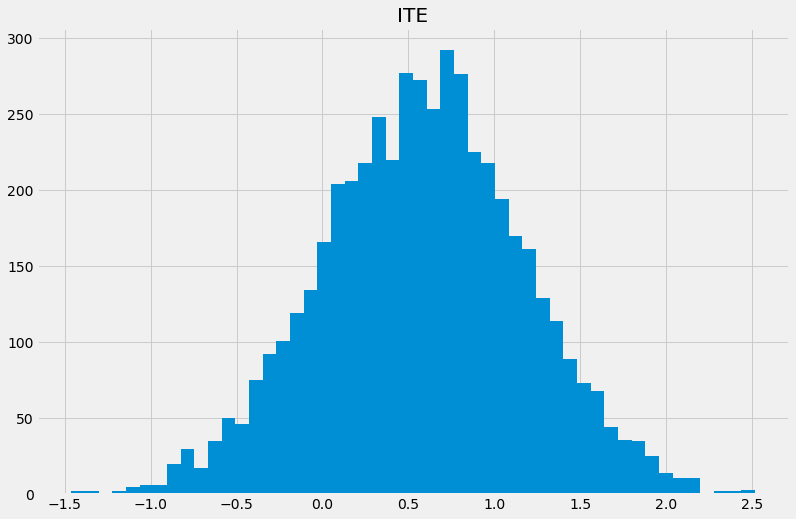

In [0]:
# visualization
ite_df.hist(column ='ITE', bins=50, grid=True, figsize=(12, 8))

In [0]:
# Calculate ATE
ATE = ite.mean()
# Print out results
print(f'The average treatment effect (ATE) is {ATE:.2f}')

The average treatment effect (ATE) is 0.58


### Segmentacija klijenata

Uplift model deli klijente u 4 grupe na osnovu inkrementalnih promena izazvanih tretmanom koji primenimo nad njima. Uobicajena primena uplift modela je u marketinske svrhe.
* Persuadables - lako ubedljivi klijenti/oni koji ce kupiti proizvod ako su tretirani, u suprotnom nece. U nasem slucaju bice definisani kao oni klijenti kojima je ITE > 0.5
* Sleeping dogs - klijenti koji ce kupovati proizvod ukoliko ih ne ometamo, ukoliko ih tretiramo nece kupovati. U nasem slucaju su oni sa ITE < -0.5.
* Lost Causes - klijenti koji nece kupovati nevezano da li su tretirani ili nisu.
* Sure things - klijenti koji ce sigurno kupiti proizvod bez obzira da li su tretirani ili nisu.

Poslednja dva slucaja cemo grupisati kao *no_impact* ukoliko je -0.5 < ITE < 0.5. Njihov efekat tretmana je blizu 0, smatramo da kontaktiranjem ovih klijenata mozemo samo da izgubimo resurse.

In [0]:
# Create the segmentation function
def segmentation(x):
  if x < -0.5:
    return 'sleeping-dog'
  elif x > 0.5:
    return 'persuadable'
  else:
    return 'no_impact'

# Apply the function 
ite_df['segment'] = ite_df['ITE'].apply(segmentation)

# Take a look at the data
ite_df.head()

,ITE,with_treatment_predict,without_treatment_predict,segment
0,1.226934,1.838433,0.611499,persuadable
1,-0.888494,1.246431,2.134924,sleeping-dog
2,0.761041,1.922170,1.161129,persuadable
3,1.079736,1.361647,0.281911,persuadable
4,0.935339,1.363661,0.428322,persuadable


Out[13]: <AxesSubplot:xlabel='segment', ylabel='count'>

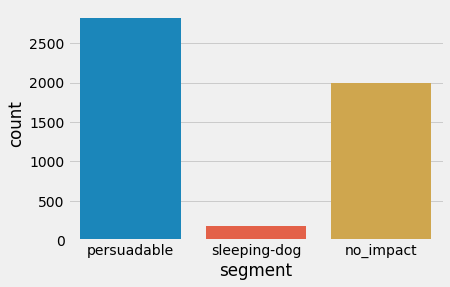

In [0]:
# Visualization
sns.countplot(x=ite_df['segment'])